# PyTorch version of the segmentation of Oxford pet dataset 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
!cp -r oxford-iiit-pet/oxford-iiit-pet/*.tar.gz ../../

In [7]:
# %cd ../../
%mkdir oxford-iiit-pet
%mkdir oxford-iiit-pet/oxford-iiit-pet/

In [8]:
!mv *.tar.gz oxford-iiit-pet/oxford-iiit-pet/

In [11]:
# %cd oxford-iiit-pet/oxford-iiit-pet/
# !tar -xvzf images.tar.gz
# !tar -xvzf annotations.tar.gz

In [12]:
%cd /content/

/content


In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
import glob
import cv2
import torchvision
import torchvision.transforms as T


In [93]:
config = {
    'batchsize': 64,
    'device': 'cuda',
    'num_epochs': 20,
}

In [94]:
import os
len(os.listdir('oxford-iiit-pet/oxford-iiit-pet/annotations/trimaps'))

14780

In [95]:
# adapted from https://www.kaggle.com/code/itsuki9180/hubmap-train
class OxfordPetDataset(torch.utils.data.Dataset):
  def __init__(self, imgs, masks, lists, transforms):
    self.transforms = transforms 
    self.imgs = [imgs +"/" + i + ".jpg" for i in lists]
    self.masks = [(masks +"/" + i + ".png") for i in lists] 
    # self.masks = glob.glob(masks + '/*')
  def __getitem__(self, idx):
    image_path = self.imgs[idx]
    mask_path = self.masks[idx]
    img = cv2.imread(image_path)
    mask = cv2.imread(mask_path)
    img = torch.tensor(img)/255.
    mask = torch.tensor(mask)
    img = img.permute([2,0,1])
    mask = mask.permute([2,0,1]) -1
    
    if self.transforms:
      both = torch.cat([img, mask], dim=0)
      both = self.transforms(both)
      (img, mask) = torch.split(both,3,0)
    return img.to(torch.float32), (mask).to(torch.int32)
  def __len__(self):
    return len(self.imgs)


In [96]:
common_transform=T.Compose([
            T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
            # Random Horizontal Flip as data augmentation.
            # T.RandomHorizontalFlip(),
        ])
import pandas as pd
df = pd.read_csv('oxford-iiit-pet/oxford-iiit-pet/annotations/list.txt', delimiter=" ",skiprows=5)
ds = OxfordPetDataset('oxford-iiit-pet/oxford-iiit-pet/images','oxford-iiit-pet/oxford-iiit-pet/annotations/trimaps',df['#images'].values,common_transform)

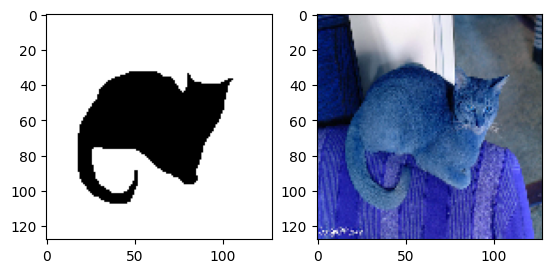

In [97]:
plt.subplot(121)
plt.imshow(ds[12][1].permute([1,2,0])/3*255)
plt.subplot(122)
plt.imshow(ds[12][0].permute([1,2,0]))

In [98]:
train_dataset, val_dataset = torch.utils.data.random_split(ds, [0.8, 0.2])


In [99]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,config['batchsize'],shuffle=True, num_workers=1,)
val_dataloader = torch.utils.data.DataLoader(val_dataset,config['batchsize'],shuffle=True, num_workers=1,)

Build a unet with pretrained mobilenetv2

In [100]:
mobilenetv2 = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2',pretrained=True).to(config['device'])
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
# TEST the pertained model
x = torch.randn((2,3,128,128)).to(config['device'])
    
for i in [2, 4, 7, 14]:
    mobilenetv2.features[i].conv[0].register_forward_hook(get_activation('l%d'%i))    
mobilenetv2.features[17].register_forward_hook(get_activation('l17'))    
out = mobilenetv2(x)
for i in [2, 4, 7, 14]:
    print(activation['l%d'%i].shape)
print(activation['l17'].shape)

class ResBlock(nn.Module):
    def __init__(self, in_channel, filters):
        super(ResBlock,self).__init__()
        self.conv =nn.ConvTranspose2d(in_channel, filters, kernel_size=4, stride=2, padding=1)
        self.normal = nn.BatchNorm2d(filters)
        self.dropout = nn.Dropout(0.5)
        self.relu6 = nn.ReLU6()
    def forward(self,x):
        x = self.conv(x)
        x = self.normal(x)
        x = self.dropout(x)
        x = self.relu6(x)
        return x
        
class unet(nn.Module):
    def __init__(self, output_channels: int):
        super(unet,self).__init__()
        self.up_stack = nn.ModuleList([ResBlock(320,512), ResBlock(1088,256), ResBlock(448,128), ResBlock(272,64)])
        self.last = nn.ConvTranspose2d(160,output_channels,kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        with torch.no_grad():
            _ = mobilenetv2(x)
            skips = [activation['l%d'%i] for i in [2, 4, 7, 14, 17]]
        x = skips[-1]
        skips = reversed(skips[:-1])
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = torch.concat([x, skip], dim=1)
        return self.last(x)
    

torch.Size([2, 96, 64, 64])
torch.Size([2, 144, 32, 32])
torch.Size([2, 192, 16, 16])
torch.Size([2, 576, 8, 8])
torch.Size([2, 320, 4, 4])


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [101]:
model = unet(3).to(config['device'])

In [102]:
from torchsummary import summary
batch_size = 16
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 8, 8]       2,621,952
       BatchNorm2d-2            [-1, 512, 8, 8]           1,024
           Dropout-3            [-1, 512, 8, 8]               0
             ReLU6-4            [-1, 512, 8, 8]               0
          ResBlock-5            [-1, 512, 8, 8]               0
   ConvTranspose2d-6          [-1, 256, 16, 16]       4,456,704
       BatchNorm2d-7          [-1, 256, 16, 16]             512
           Dropout-8          [-1, 256, 16, 16]               0
             ReLU6-9          [-1, 256, 16, 16]               0
         ResBlock-10          [-1, 256, 16, 16]               0
  ConvTranspose2d-11          [-1, 128, 32, 32]         917,632
      BatchNorm2d-12          [-1, 128, 32, 32]             256
          Dropout-13          [-1, 128, 32, 32]               0
            ReLU6-14          [-1, 128,

In [103]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

Train the model

In [104]:
losses = []
val_losses = []
from tqdm import tqdm
for epoch in range(config['num_epochs']):
  for i, (image, label) in enumerate(tqdm(train_dataloader)):
    label_p = model(image.to(config['device']))
    loss = criterion(label_p,label[:,0].long().to(config['device']))
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    del image, label_p, label
    del loss
    torch.cuda.empty_cache()
  for ii, (image_v, label_v) in enumerate(tqdm(val_dataloader)):
    with torch.no_grad():
      label_p_v = model(image_v.to(config['device']))
      val_loss = criterion(label_p_v,label_v[:,0].long().to(config['device']))
      val_losses.append(val_loss.item())
      del image_v, label_p_v, label_v
      del val_loss
      torch.cuda.empty_cache()
  # print(loss.item(),val_loss.item())
  print(losses[-1], val_losses[-1])





100%|██████████| 23/23 [00:10<00:00,  2.27it/s]


0.39594507217407227 0.41303572058677673


100%|██████████| 23/23 [00:11<00:00,  1.99it/s]


0.34471580386161804 0.43603479862213135


100%|██████████| 23/23 [00:11<00:00,  2.00it/s]


0.3667520582675934 0.32374143600463867


100%|██████████| 23/23 [00:11<00:00,  2.03it/s]


0.3016818165779114 0.40475937724113464


100%|██████████| 23/23 [00:10<00:00,  2.16it/s]


0.2793737053871155 0.25893622636795044


100%|██████████| 23/23 [00:11<00:00,  2.01it/s]


0.23184920847415924 0.2961311340332031


100%|██████████| 23/23 [00:11<00:00,  2.00it/s]


0.22590340673923492 0.31231003999710083


100%|██████████| 23/23 [00:11<00:00,  2.01it/s]


0.23931705951690674 0.29734811186790466


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


0.2146448791027069 0.33206096291542053


100%|██████████| 23/23 [00:11<00:00,  1.98it/s]


0.2273373305797577 0.2828461527824402


100%|██████████| 23/23 [00:11<00:00,  1.99it/s]


0.20291545987129211 0.30703991651535034


100%|██████████| 23/23 [00:11<00:00,  2.00it/s]


0.20596985518932343 0.4116761386394501


100%|██████████| 23/23 [00:11<00:00,  2.05it/s]


0.1920841932296753 0.24645450711250305


100%|██████████| 23/23 [00:11<00:00,  2.00it/s]


0.17483079433441162 0.2649897038936615


100%|██████████| 23/23 [00:11<00:00,  1.99it/s]


0.19932809472084045 0.28258955478668213


100%|██████████| 23/23 [00:10<00:00,  2.18it/s]


0.1903192549943924 0.27253660559654236


100%|██████████| 23/23 [00:11<00:00,  1.98it/s]


0.18274934589862823 0.35237786173820496


100%|██████████| 23/23 [00:11<00:00,  2.00it/s]


0.18781815469264984 0.3192465007305145


100%|██████████| 23/23 [00:11<00:00,  2.01it/s]


0.16372144222259521 0.2764910161495209


100%|██████████| 23/23 [00:10<00:00,  2.18it/s]

0.16739174723625183 0.2803824543952942


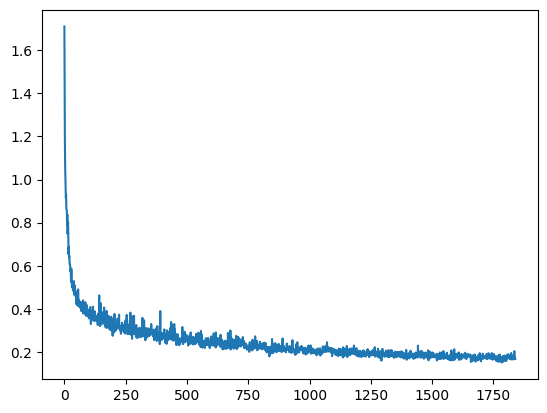

In [115]:
plt.plot(losses)

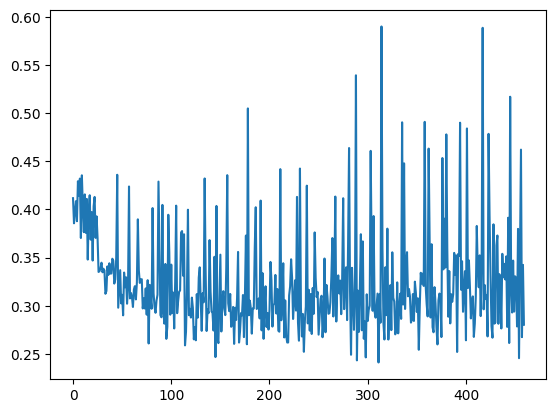

In [114]:
plt.plot(val_losses)

In [108]:
for image, label in val_dataloader:
  label_p = model(image.to(config['device']))
  break

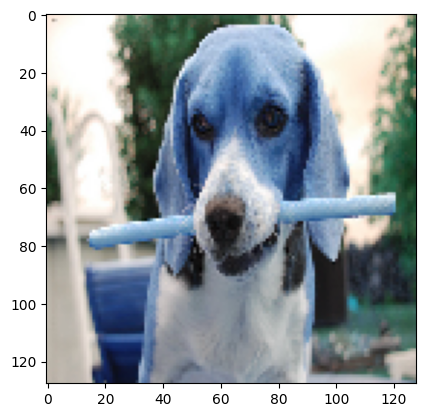

In [109]:
plt.imshow(image[0].permute(1,2,0))

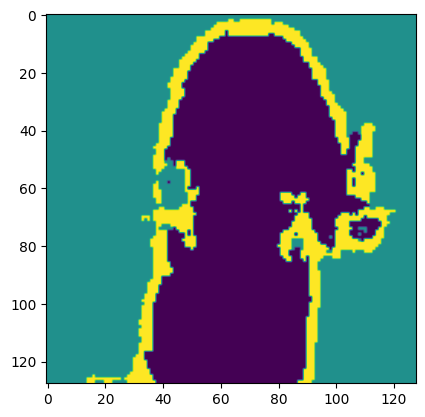

In [110]:
plt.imshow(torch.argmax(label_p[0],dim=0).detach().cpu())

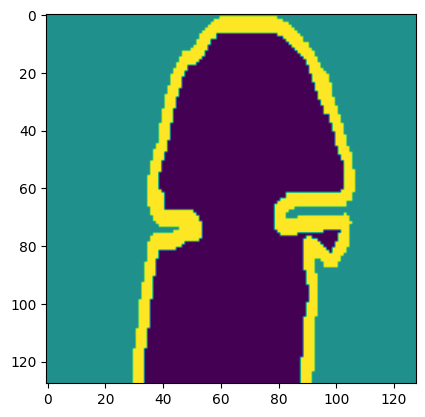

In [111]:
plt.imshow(label[0][0])